# Experiment Template


**In this notebook:**

* Load original mri data + aneurysm mask
* Resample Images to 1.5 mm Voxelsize
* Filter images based on size
* Train network to predict vessel mask
* Evaluate aneurysm mask

**Todo:**
* Check percentage of 1s in resampled mask
* Write evaluation
* Try out different batch_sizes

## Dependencies
Install, load, and initialize all required dependencies for this experiment.

### Install Dependencies

In [ ]:
#It should be possible to run the notebook independent of anything else. 
# If dependency cannot be installed via pip, either:
# - download & install it via %%bash
# - atleast mention those dependecies in this section

import sys
!{sys.executable} -m pip install -q -e ../../utils/


### Import Dependencies

In [3]:
!{sys.executable} -m pip list

Package                  Version     Location
------------------------ ----------- ---------------------------------
addict                   2.4.0
aneurysm-detection-utils 0.0.0       /workspaces/our-git-project/utils
appdirs                  1.4.4
argon2-cffi              20.1.0
ase                      3.21.1
async-generator          1.10
attrs                    21.2.0
backcall                 0.2.0
bids-validator           1.7.2
bleach                   3.3.0
certifi                  2021.5.30
cffi                     1.14.5
chardet                  4.0.0
click                    8.0.1
colorcet                 2.0.6
comet-ml                 3.12.0
configobj                5.0.6
cycler                   0.10.0
decorator                5.0.7
defusedxml               0.7.1
distro                   1.5.0
docopt                   0.6.2
dulwich                  0.20.23
entrypoints              0.3
et-xmlfile               1.1.0
everett                  1.0.3
gitdb                    4.0

# System libraries

In [2]:
from __future__ import absolute_import, division, print_function
import logging, os, sys

# Enable logging
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO, stream=sys.stdout)

# Re-import packages if they change
%load_ext autoreload
%autoreload 2

# Recursion Depth
import sys
sys.setrecursionlimit(10000)

# Intialize tqdm to always use the notebook progress bar
import tqdm
tqdm.tqdm = tqdm.tqdm_notebook

# Third-party libraries
import comet_ml
import numpy as np
import pandas as pd
import nilearn.plotting as nip
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import collections
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,6)
%config InlineBackend.figure_format='retina'  # adapt plots for retina displays
import git


# Project utils

import aneurysm_utils
from aneurysm_utils import evaluation, training


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


OSError: /usr/local/lib/python3.8/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN3c106detail12infer_schema20make_function_schemaENS_8ArrayRefINS1_11ArgumentDefEEES4_

### Initialize Environment

In [4]:
env = aneurysm_utils.Environment(project="our-git-project", root_folder="/workspaces/")
env.cached_data["comet_key"] = "EGrR4luSis87yhHbs2rEaqAWs" 
env.print_info()

Environment Info:

Library Version: 0.1.0
Configured Project: our-git-project

Folder Structure: 
- Root folder: /workspaces
 - Project folder: /workspaces/our-git-project
 - Datasets folder: /workspaces/our-git-project/datasets
 - Models folder: /workspaces/our-git-project/models
 - Experiments folder: /workspaces/our-git-project/experiments


## Load Data
Download, explore, and prepare all required data for the experiment in this section.

In [15]:
dataset_params = {
    "prediction": "mask",
    "mri_data_selection": "", 
    "balance_data": False,
    "seed": 1,
    "resample_voxel_dim": (1.5, 1.5, 1.5)
}

preprocessing_params = {
    'min_max_normalize': True,
    'mean_std_normalize': False,
    'smooth_img': False, # can contain a number: smoothing factor
    'intensity_segmentation':True
}


### Load Meta Data

In [35]:
from aneurysm_utils.data_collection import load_aneurysm_dataset

df = load_aneurysm_dataset(
    env,
    mri_data_selection=dataset_params["mri_data_selection"],
    random_state=dataset_params["seed"]
)
df.head()

,Aneurysm Geometry,Angiography Data,Vessel Geometry,Labeled Mask Index,Location,Age,Sex,Rupture Status,Age Bin,Aneurysm Count,Case,Path Orig,Path Mask,Path Vessel,Path Labeled Mask
0,A001.stl,A001_orig.nii.gz,A001_vessel.stl,1,Acom,48,m,1.0,"(40, 50]",1,A001,/workspaces/our-git-project/datasets/A001_orig...,/workspaces/our-git-project/datasets/A001_mask...,/workspaces/our-git-project/datasets/A001_vess...,/workspaces/our-git-project/datasets/A001_labe...
1,A003.stl,A003_orig.nii.gz,A003_vessel.stl,1,Pcom,58,f,0.0,"(50, 60]",1,A003,/workspaces/our-git-project/datasets/A003_orig...,/workspaces/our-git-project/datasets/A003_mask...,/workspaces/our-git-project/datasets/A003_vess...,/workspaces/our-git-project/datasets/A003_labe...
2,A005.stl,A005_orig.nii.gz,A005_vessel.stl,1,PICA,45,m,1.0,"(40, 50]",1,A005,/workspaces/our-git-project/datasets/A005_orig...,/workspaces/our-git-project/datasets/A005_mask...,/workspaces/our-git-project/datasets/A005_vess...,/workspaces/our-git-project/datasets/A005_labe...
3,A006.stl,A006_orig.nii.gz,A006_vessel.stl,1,ACom,46,f,1.0,"(40, 50]",1,A006,/workspaces/our-git-project/datasets/A006_orig...,/workspaces/our-git-project/datasets/A006_mask...,/workspaces/our-git-project/datasets/A006_vess...,/workspaces/our-git-project/datasets/A006_labe...
4,A008.stl,A008_orig.nii.gz,A008_vessel.stl,1,ACA,72,f,0.0,"(70, 80]",1,A008,/workspaces/our-git-project/datasets/A008_orig...,/workspaces/our-git-project/datasets/A008_mask...,/workspaces/our-git-project/datasets/A008_vess...,/workspaces/our-git-project/datasets/A008_labe...


### Load & Split MRI Data

In [36]:
# Load MRI images and split into train, test, and validation
from aneurysm_utils.data_collection import split_mri_images
case_list = ["A001","A003","A005","A006","A008", "A010", "A012","A009"]
df = df.loc[df["Case"].isin(case_list)]

train_data, test_data, val_data, _ = split_mri_images(
    env, 
    df, 
    prediction=dataset_params["prediction"], 
    encode_labels=False,
    random_state=dataset_params["seed"],
    balance_data=dataset_params["balance_data"],
    resample_voxel_dim=dataset_params["resample_voxel_dim"]
)

mri_imgs_train, labels_train = train_data
mri_imgs_test, labels_test = test_data
mri_imgs_val, labels_val = val_data

8
7
         Images
-----  --------
All           8
Train         6
Val           1
Test          1



  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [37]:
from aneurysm_utils import preprocessing

preprocessing.check_mri_shapes(mri_imgs_train)

Most common:
(47, 47, 40):       3
(93, 93, 80):       2
(47, 47, 41):       1


## Transform & Preprocess Data

In [38]:
from aneurysm_utils import preprocessing

size_of_train = len(mri_imgs_train)
size_of_test = len(mri_imgs_test)
size_of_val = len(mri_imgs_val)

# preprocess all lists as one to have a working mean_std_normalization
mri_imgs = mri_imgs_train + mri_imgs_test + mri_imgs_val
mri_imgs = preprocessing.preprocess(env, mri_imgs, preprocessing_params)

mri_imgs_train = mri_imgs[:size_of_train]
mri_imgs_train = [train for train in mri_imgs_train]
mri_imgs_test = mri_imgs[size_of_train : size_of_train + size_of_test]
mri_imgs_test = [test for test in mri_imgs_test]
mri_imgs_val = mri_imgs[size_of_train + size_of_test :]
mri_imgs_val = [val for val in mri_imgs_val]

# preprocess mask
x, y, h = labels_train[0].shape
labels_train = [label_train for label_train in labels_train]
labels_test = [label_test for label_test in labels_test]
labels_val = [label_val for label_val in labels_val]
# flatten

[INFO] Preprocessing: Min Max Normalize...


In [39]:
train_index = [i for i, e in enumerate(mri_imgs_train) if e.shape != (93, 93, 80)]
mri_imgs_train = [i for j, i in enumerate(mri_imgs_train) if j not in train_index]
labels_train = [i for j, i in enumerate(labels_train) if j not in train_index]

test_index = [i for i, e in enumerate(mri_imgs_test) if e.shape != (93, 93, 80)]
mri_imgs_test = [i for j, i in enumerate(mri_imgs_test) if j not in test_index]
labels_test = [i for j, i in enumerate(labels_test) if j not in test_index]

val_index = [i for i, e in enumerate(mri_imgs_val) if e.shape != (93, 93, 80)]
mri_imgs_val = [i for j, i in enumerate(mri_imgs_val) if j not in val_index]
labels_val = [i for j, i in enumerate(labels_val) if j not in val_index]

mri_imgs_train[0].shape
preprocessing.check_mri_shapes(mri_imgs_train)
print(np.unique(labels_val[0], return_counts=True))

Most common:
(93, 93, 80):       2
(array([0., 1.], dtype=float32), array([691892,     28]))


### Optional: View image


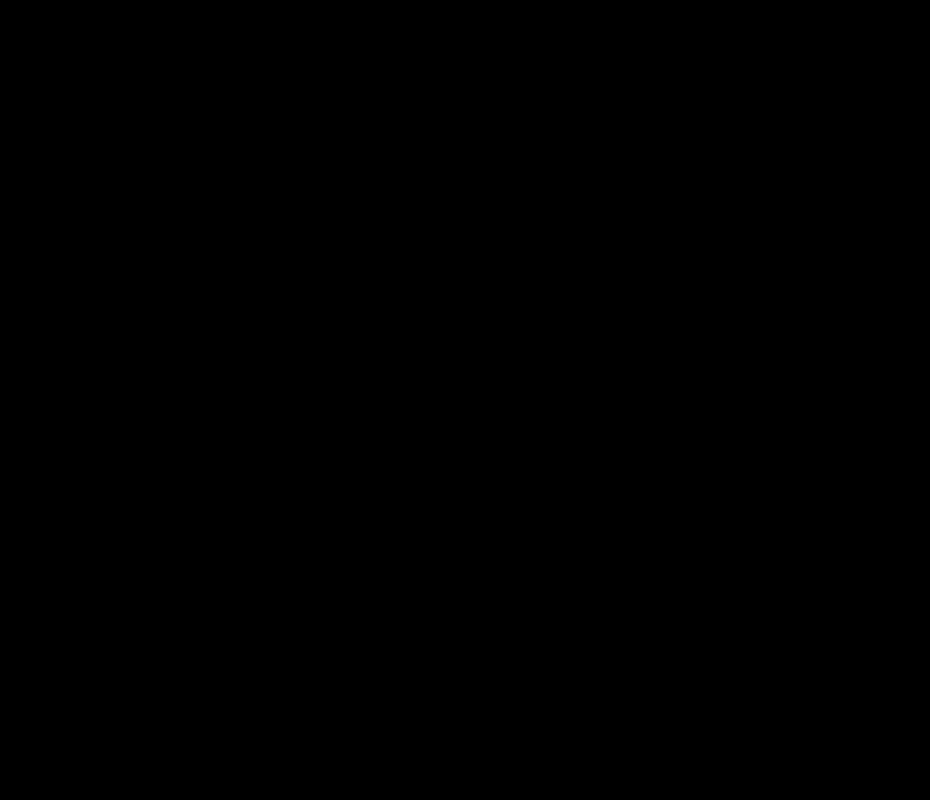
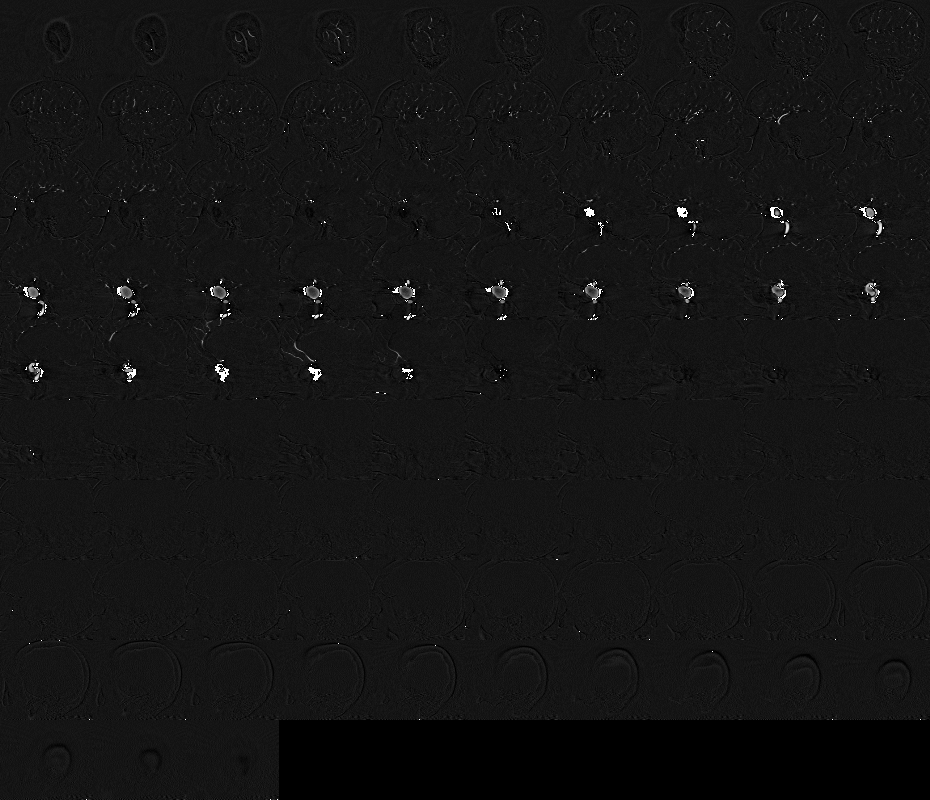

In [40]:
idx = 0
nip.view_img(
    nib.Nifti1Image(mri_imgs_train[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)

In [41]:
evaluation.plot_slices(mri_imgs_train[0])

0.0 1.0 None None


## Train Model
Implementation, configuration, and evaluation of the experiment.

### Train Deep Model 3D data

In [48]:
artifacts = {
    "train_data": (mri_imgs_train, labels_train),
    "val_data": (mri_imgs_val, labels_val),
    "test_data": (mri_imgs_test, labels_test)
}

# Define parameter configuration for experiment run
params = {
    "batch_size": 3,
    "epochs": 100,
    "learning_rate": 5.0e-3, # 3e-04, 1.0E-5
    "es_patience": None, # None = deactivate early stopping
    "weight_decay": 0.001, # 1e-3
    "model_name": 'SegNet',
    "optimizer_momentum": 0.9,
    "optimizer":'Adam',
    "criterion": "CrossEntropyLoss", 
    "criterion_weights": [1.0, 1000.0], # [1.75, 1.0],
    "sampler": None,   #'ImbalancedDatasetSampler2',
    "shuffle_train_set": True,
    "scheduler": "ReduceLROnPlateau", # "ReduceLROnPlateau",
    "save_models": False,
    "debug": True,
}

params.update(dataset_params)
params.update(preprocessing_params)

# data augmentation

In [51]:
# Run experiment and sync all metadata
exp = env.create_experiment(
    params["prediction"] + "-pytorch-" + params["model_name"],
    comet_ml.Experiment(
        env.cached_data["comet_key"],
        project_name=env.project + "-" + params["prediction"],
        disabled=params["debug"],
    ),
)
exp.run(env,training.train_pytorch_model, params, artifacts)

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/rbendias/our-git-project-mask/3f8b5f7bde124ca0a0372ef3946d5a95
COMET INFO:   Others:
COMET INFO:     Name : 2021-06-12-13-36-45_mask-pytorch-segnet
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (1 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     os packages              : 1
COMET INFO: ---------------------------
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/rbendias/our-git-project-mask/41

TypeError: run() takes from 2 to 4 positional arguments but 5 were given

## Evaluate Model

Do evaluation, e.g. visualizations  

In [14]:
from aneurysm_utils.utils.pytorch_utils import predict

In [15]:
model = exp.artifacts["model"]

In [16]:
predictions = predict(model, mri_imgs_val,apply_softmax=False )

In [20]:
predictions[0][1]

array([[[2.6956425, 2.5230427, 2.5297809, ..., 2.5164292, 2.5239413,
         2.7135153],
        [2.494128 , 2.242309 , 2.2423267, ..., 2.2231643, 2.2296388,
         2.5174057],
        [2.4889317, 2.2341   , 2.2377336, ..., 2.2210717, 2.219593 ,
         2.5121012],
        ...,
        [2.464195 , 2.2000973, 2.2085664, ..., 2.2353754, 2.23292  ,
         2.5163288],
        [2.4662642, 2.2060084, 2.1947322, ..., 2.2213666, 2.2289543,
         2.5144582],
        [2.6772013, 2.486663 , 2.4655454, ..., 2.4896693, 2.4953682,
         2.7005544]],

       [[2.504393 , 2.2565825, 2.2576828, ..., 2.250914 , 2.2586796,
         2.5332484],
        [2.2096472, 1.8437998, 1.8432616, ..., 1.832525 , 1.8395432,
         2.2532864],
        [2.209936 , 1.836369 , 1.837262 , ..., 1.831311 , 1.8285838,
         2.2414927],
        ...,
        [2.1885605, 1.8142493, 1.8110644, ..., 1.8427839, 1.8476356,
         2.2523446],
        [2.1880183, 1.8108612, 1.8027688, ..., 1.8325309, 1.839912 ,
   


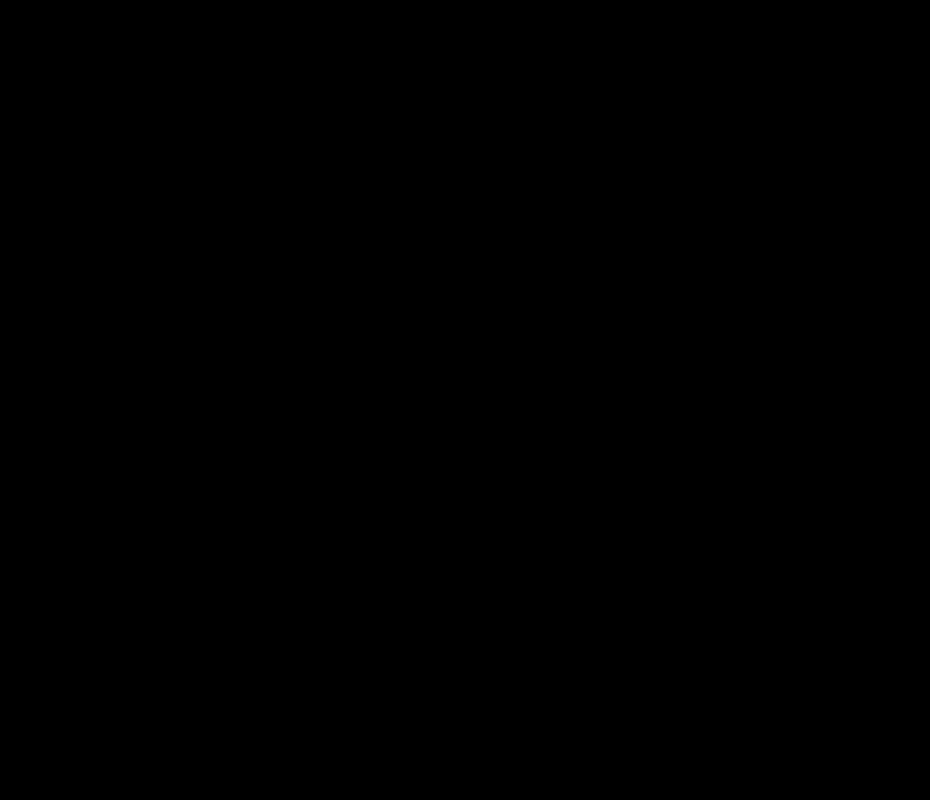
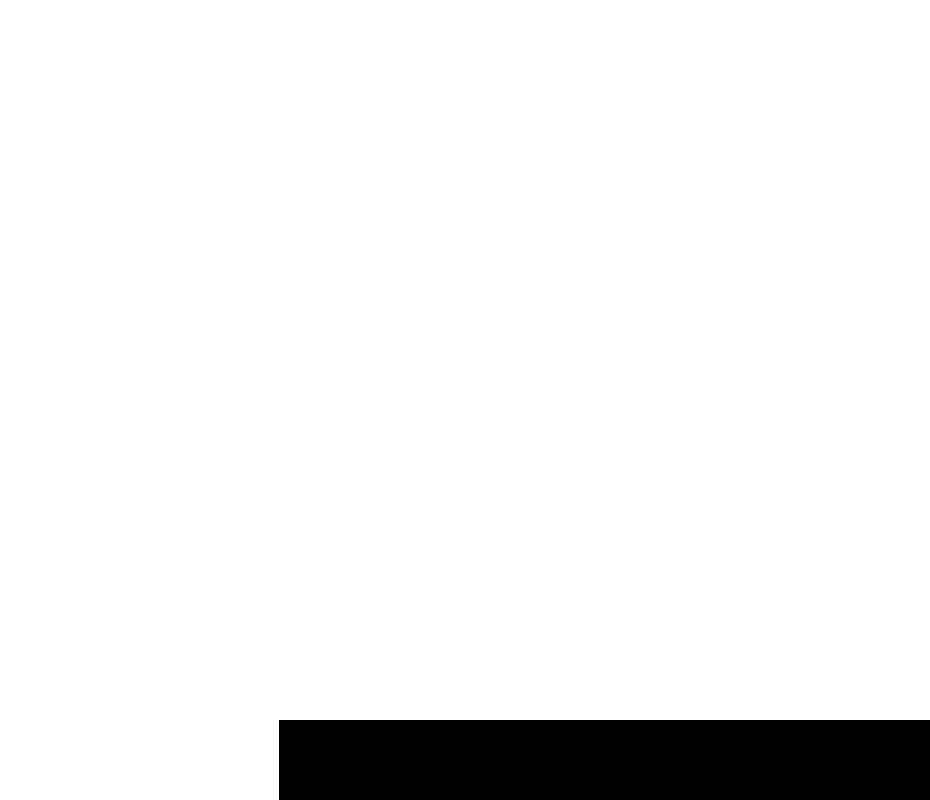

In [17]:

idx = 0
nip.view_img(
    nib.Nifti1Image(predictions[0][0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)


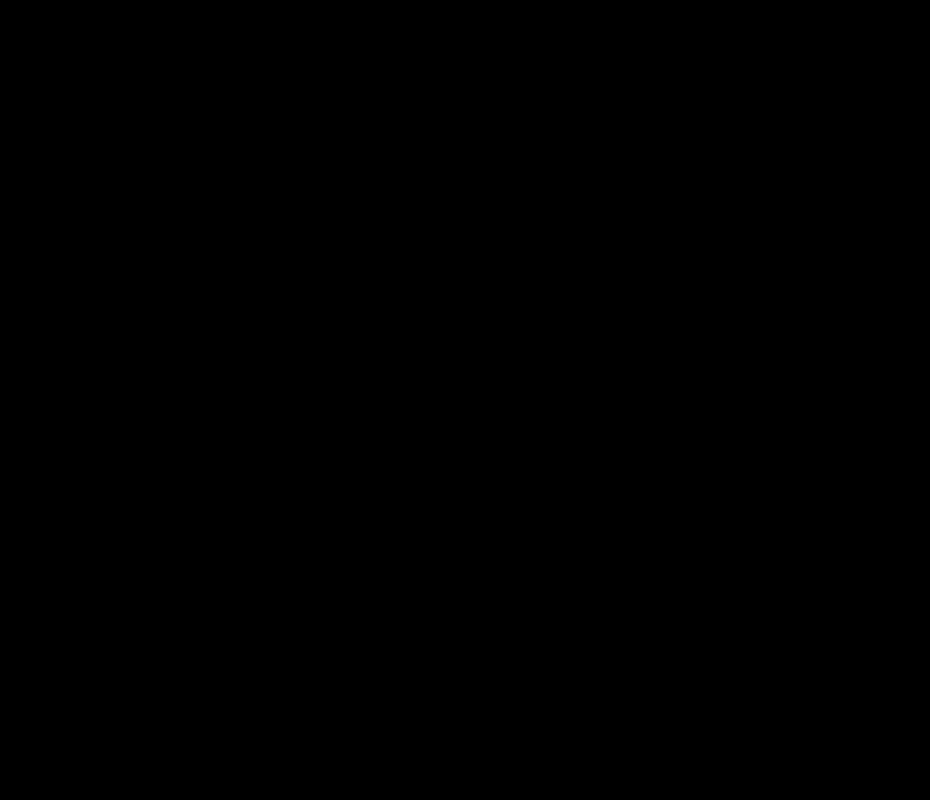
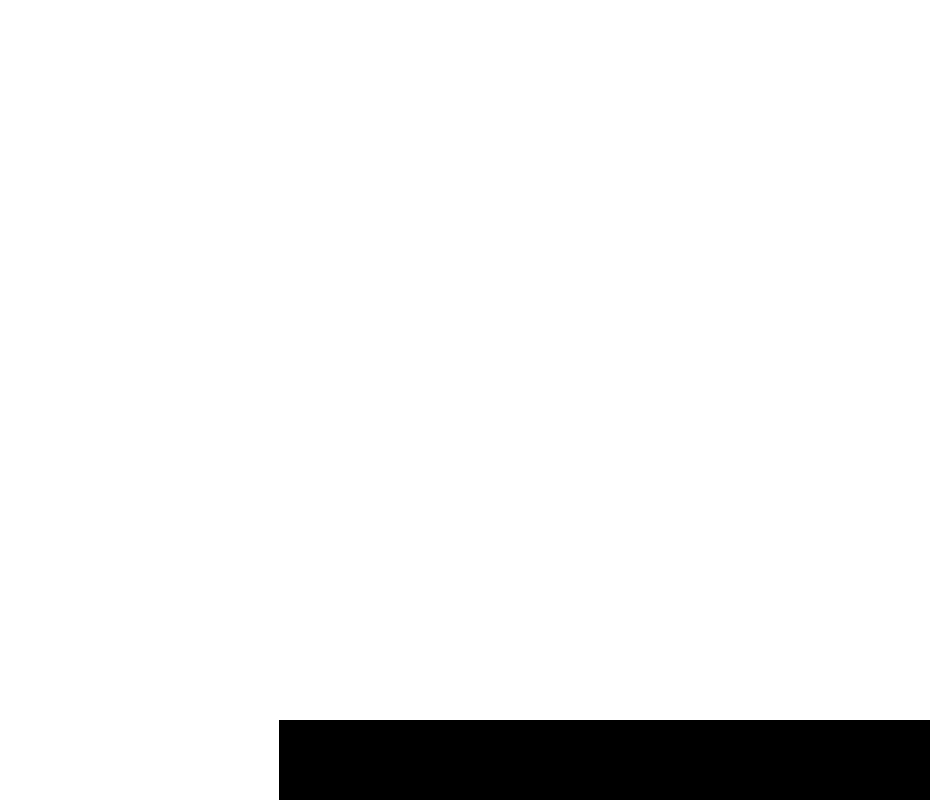

In [18]:
idx = 0
nip.view_img(
    nib.Nifti1Image(labels_val[0], np.eye(4)),
    symmetric_cmap=False,
    cmap="Greys_r",
    bg_img=False,
    black_bg=True,
    threshold=1e-03, 
    draw_cross=False
)